<a href="https://colab.research.google.com/github/Vedhapriyakoppula/Fmml-lab-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 05:53:23--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.43, 18.172.170.8, 18.172.170.53, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   169MB/s    in 0.3s    

2024-05-12 05:53:24 (169 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


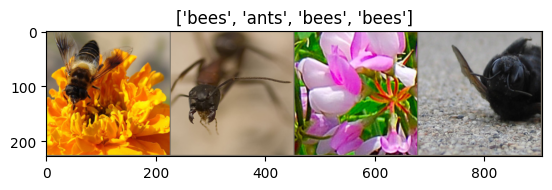

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.3MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.8070 Acc: 0.6352

Epoch 1/4
----------
Loss: 0.5608 Acc: 0.7582

Epoch 2/4
----------
Loss: 0.3363 Acc: 0.8484

Epoch 3/4
----------
Loss: 0.4885 Acc: 0.7910

Epoch 4/4
----------
Loss: 0.4993 Acc: 0.8115



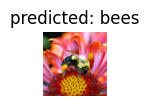

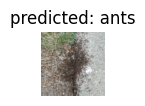

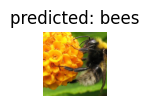

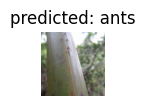

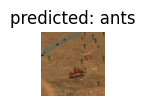

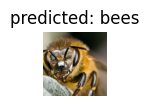

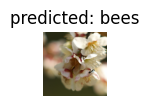

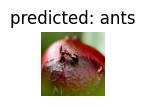

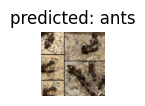

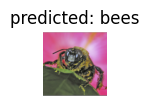

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


ANSWER 1

1. Increased Dataset Size and Diversity:

Limited real-world data is a common challenge in machine learning. Data augmentation techniques like resize, crop, and random transformations (flips, rotations) help artificially expand the training dataset.
By creating variations of existing images, these techniques ensure the model encounters a wider range of data during training. This improves the model's ability to generalize to unseen data, reducing the risk of overfitting.
2. Improved Invariance to Transformations:

Real-world images can undergo various transformations, such as changes in scale, position, and orientation. Data augmentation helps the model learn features that are invariant to these transformations.
For example, by training on resized and cropped images, the model learns to identify the relevant features regardless of the object's size or position within the image.
3. Reduced Overfitting:

Overfitting occurs when a model memorizes the training data too well and performs poorly on unseen examples. Data augmentation helps prevent this by introducing variations in the training data.
The model is forced to learn more generalizable features that apply to a broader range of possible inputs, not just the specific training examples.
Specific Techniques and Benefits:

Resize: Images can be resized to different sizes within a reasonable range. This helps the model learn features that are not dependent on a specific image resolution.
Crop: Random cropping extracts smaller regions from the original image, forcing the model to focus on relevant features within those regions. This can be particularly helpful for object detection tasks.
Random Flips (Horizontal/Vertical): Flipping images horizontally or vertically creates new variations while preserving the object's identity. This helps the model learn features that are not dependent on the object's orientation.
Rotations: Randomly rotating images by small angles helps the model learn features that are rotation-invariant.

ANSWER 2

Lower Accuracy:

A model trained from scratch lacks the knowledge learned from a massive dataset (e.g., ImageNet) that a pre-trained model possesses. This can lead to lower accuracy on your specific task, especially if your dataset is relatively small.
Slower Training:

Training a model from scratch requires learning all the parameters from the beginning. This can be a significantly slower process compared to fine-tuning a pre-trained model, which already has learned weights for many lower-level features.
Higher Risk of Overfitting:

With a limited dataset, training from scratch can lead to overfitting. The model might memorize the training data too well and perform poorly on unseen examples. Techniques like data augmentation and regularization become even more crucial in this scenario.
Potential Benefits (in Specific Cases):

In rare cases, if your dataset is very large and highly specific to your task domain, training from scratch might allow the model to learn optimal features directly for that task. However, this is uncommon.
Here's a table summarizing the comparison:

Feature	Pre-trained ResNet	ResNet Trained from Scratch
Accuracy	Higher	Lower (potentially)
Training Time	Faster	Slower
Overfitting Risk	Lower	Higher
Generalizability	Better	May be specific to training data

drive_spreadsheet
Export to Sheets
Important Note:

In most practical scenarios, using a pre-trained ResNet model with fine-tuning is the recommended approach. It leverages the pre-trained knowledge as a strong starting point, often achieving good accuracy with less training time and a lower risk of overfitting, even with moderate-sized datasets.


ANSWER 3

The performance of a pre-trained ResNet model on an ants vs. bees classification task can be affected by how significantly different the pre-training dataset is from your target data. Here's a breakdown of the factors at play:

Transfer Learning and Generalizability:

Pre-trained models like ResNet are powerful because they learn general, low-level features like edges, shapes, and textures applicable to various image recognition tasks. These features can be a good starting point for fine-tuning on a new dataset like ants vs. bees, even if the pre-training dataset is different.
Impact of Dataset Dissimilarity:

The more similar the pre-training dataset is to the target data (ants vs. bees), the better the pre-trained features will be aligned with the task. For example, a pre-trained model on a dataset containing many insects might be more suitable than one trained on generic objects.
Significant differences can lead to a performance drop. For instance, a model pre-trained on everyday objects might not have optimal feature representations for distinguishing subtle differences between ants and bees.
Strategies to Mitigate Dissimilarity:

Fine-tuning the later layers: This is a key strategy in transfer learning. By retraining only the final layers of the pre-trained model on your specific data (ants vs. bees), you allow the model to adapt the learned features to the new task.
Data Augmentation: Techniques like random cropping, flipping, and rotations can help the model learn features that are more robust to variations within the ants vs. bees data, even if they weren't explicitly present in the pre-training dataset.
Overall, you might still get good performance with a pre-trained ResNet, even for a significantly different dataset, but it depends on the degree of difference and the effectiveness of your fine-tuning approach.

Here are some additional considerations:

Size of the target dataset: A larger dataset for fine-tuning can help the model overcome the limitations of the pre-trained features and learn task-specific knowledge.
Complexity of the task: Distinguishing ants from bees is a relatively simple task compared to classifying objects with finer details. This can favor transfer learning even with some dataset dissimilarity.
In conclusion, experiment and compare:

Try using a pre-trained ResNet model with fine-tuning on your ants vs. bees dataset.
If the performance isn't satisfactory, explore alternative pre-trained models with datasets potentially closer to the target domain (insects) or consider training a model from scratch, but be prepared for potentially longer training times and higher risk of overfitting, especially with a small dataset.